# Traffic Light Classifier


If you are using deep learning approach, dont get fancy like training using big network, or other data bases like coco, bosch traffic light etc. Atleast approach I took was to dump all the images from simulator and ros bag file, used Tensor flow OD API, MobileNet SSD, hand annotated simulator and site images (annotated around 2500 images) and train. Thats it. Simulator accuracy is very good, but site images accuracy for RED and YELLOW is poor, GREEN works. Need more examples of RED and YELLOW traffic lights to improve accuracy. I referred to fantastic hands-on tutorial on youtube by Sentdex - https://www.youtube.com/watch?v=COlbP62-B-U&list=PLQVvvaa0QuDcNK5GeCQnxYnSSaar2tpku

## Step 0: Load The Data

In [89]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../data/train.p'
validation_file= '../data/valid.p'
testing_file = '../data/test.p'

X_train, y_train, X_valid, y_valid, X_test, y_test = None, None, None, None, None, None

def load_data():
    
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    global X_train, y_train, X_valid, y_valid, X_test, y_test
    X_train, y_train = train['features'], train['labels']
    X_valid, y_valid = valid['features'], valid['labels']
    X_test, y_test = test['features'], test['labels']
    
load_data()

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [90]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = y_train.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

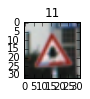

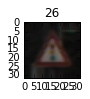

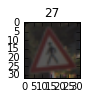

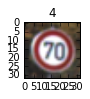

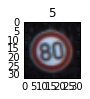

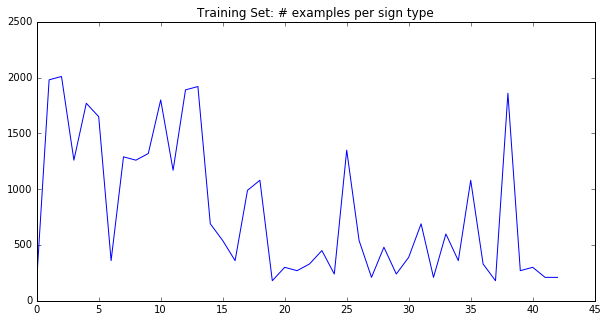

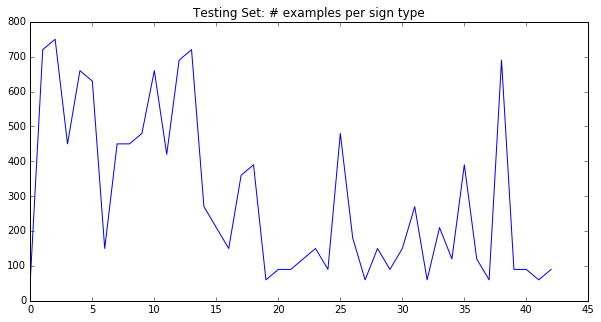

In [91]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random


num_images = 5
for i in range(num_images):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()

    plt.figure(figsize=(1,1))
    plt.title(y_train[index])
    plt.imshow(image)


train_sign_count_map = {}
for label in y_train:
    if label not in train_sign_count_map:
        train_sign_count_map[label] = 0
    train_sign_count_map[label] += 1
    
idxs = list(train_sign_count_map.keys())
sign_counts = list(train_sign_count_map.values())
plt.figure(figsize=(10,5))
plt.title('Training Set: # examples per sign type')
plt.plot(idxs, sign_counts)


test_sign_count_map = {}
for label in y_test:
    if label not in test_sign_count_map:
        test_sign_count_map[label] = 0
    test_sign_count_map[label] += 1
    
idxs = list(test_sign_count_map.keys())
sign_counts = list(test_sign_count_map.values())
plt.figure(figsize=(10,5))
plt.title('Testing Set: # examples per sign type')
plt.plot(idxs, sign_counts)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

Original
19 113
19 109
19 108
18 108
16 110
17 111
16 107
19 108
14 108
9 107
After Mean Substraction
105 194
106 195
105 192
105 191
104 196
105 193
104 192
104 189
102 196
96 191
After Normalization
0.411764705882 0.760784313725
0.41568627451 0.764705882353
0.411764705882 0.752941176471
0.411764705882 0.749019607843
0.407843137255 0.76862745098
0.411764705882 0.756862745098
0.407843137255 0.752941176471
0.407843137255 0.741176470588
0.4 0.76862745098
0.376470588235 0.749019607843


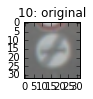

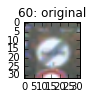

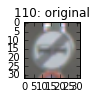

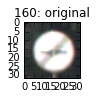

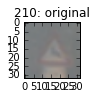

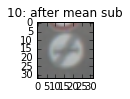

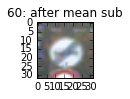

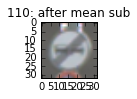

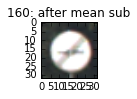

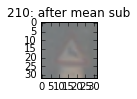

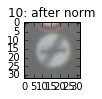

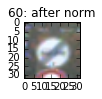

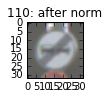

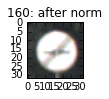

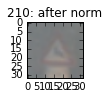

In [92]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import numpy as np

def mean_substraction(images_data):
    ncols = images_data.shape[1]
    nrows = images_data.shape[2]
    
    for i in range(images_data.shape[0]):
        
        image_data = images_data[i]
        image_data_int16 = np.ndarray.astype(image_data,dtype='int16')
        
        r_mean = np.mean(image_data[:,:,0])
        g_mean = np.mean(image_data[:,:,1])
        b_mean = np.mean(image_data[:,:,2])
        

        image_data_int16[:,:,0] = image_data_int16[:,:,0] + (128 - r_mean)
        image_data_int16[:,:,1] = image_data_int16[:,:,1] + (128 - g_mean)
        image_data_int16[:,:,2] = image_data_int16[:,:,2] + (128 - b_mean)
        
        image_data_int16[:,:,0] = np.clip(image_data_int16[:,:,0], 0, 255)
        image_data_int16[:,:,1] = np.clip(image_data_int16[:,:,1], 0, 255)
        image_data_int16[:,:,2] = np.clip(image_data_int16[:,:,2], 0, 255)

        images_data[i] = np.ndarray.astype(image_data_int16,dtype='uint8')

    return images_data
    
def normalize_images(images_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.0
    b = 1.0
    image_min = 0.0
    image_max = 255.0
    return a + ( ( (images_data - image_min)*(b - a) )/( image_max - image_min ) )

load_data()
plot_idxs = range(10,260,50)

print('Original')
for i in range(10):
    print (np.amin(X_train[i]), np.amax(X_train[i]))

for plot_idx in plot_idxs:
    plt.figure(figsize=(1,1))
    plt.title('%d: original' % (plot_idx))    
    plt.imshow(X_train[plot_idx])
    
X_train = mean_substraction(X_train)
X_valid = mean_substraction(X_valid)
X_test = mean_substraction(X_test)

for plot_idx in plot_idxs:
    plt.figure(figsize=(1,1))
    plt.title('%d: after mean sub' % (plot_idx))    
    plt.imshow(X_train[plot_idx])


print('After Mean Substraction')
for i in range(10):
    print (np.amin(X_train[i]), np.amax(X_train[i]))

X_train = normalize_images(X_train)
X_valid = normalize_images(X_valid)
X_test = normalize_images(X_test)

for plot_idx in plot_idxs:
    plt.figure(figsize=(1,1))
    plt.title('%d: after norm' % (plot_idx))    
    plt.imshow(X_train[plot_idx])

print('After Normalization')
for i in range(10):
    print (np.amin(X_train[i]), np.amax(X_train[i]))

#import numpy as np
#for i in range(100):
#    print (np.amin(X_train[i]), np.amax(X_train[i]))

### Model Architecture

In [93]:
### Define your architecture here.
### Feel free to use as many code cells as needed.


from tensorflow.contrib.layers import flatten

def LeNet_Solution_Modified(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Dropout
    conv1 = tf.nn.dropout(conv1, keep_prob)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # Dropout
    conv2 = tf.nn.dropout(conv2, keep_prob)    
    
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)

    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [94]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

import tensorflow as tf

# Setup variables
EPOCHS = 30
BATCH_SIZE = 128

# Prepare data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

# Features and lables
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

# Training Pipeline
rate = 0.001

logits = LeNet_Solution_Modified(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
# For L2 Regularization, add beta * tf.nn.l2_loss(weights) +
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy, total_loss = 0, 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss / num_examples, total_accuracy / num_examples

In [96]:
# Training Model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.9})
            
        validation_loss, validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Loss = {:.3f}".format(validation_loss))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Loss = 1.036
Validation Accuracy = 0.707

EPOCH 2 ...
Validation Loss = 0.655
Validation Accuracy = 0.827

EPOCH 3 ...
Validation Loss = 0.518
Validation Accuracy = 0.857

EPOCH 4 ...
Validation Loss = 0.465
Validation Accuracy = 0.874

EPOCH 5 ...
Validation Loss = 0.395
Validation Accuracy = 0.890

EPOCH 6 ...
Validation Loss = 0.382
Validation Accuracy = 0.890

EPOCH 7 ...
Validation Loss = 0.344
Validation Accuracy = 0.914

EPOCH 8 ...
Validation Loss = 0.328
Validation Accuracy = 0.915

EPOCH 9 ...
Validation Loss = 0.327
Validation Accuracy = 0.922

EPOCH 10 ...
Validation Loss = 0.334
Validation Accuracy = 0.912

EPOCH 11 ...
Validation Loss = 0.387
Validation Accuracy = 0.907

EPOCH 12 ...
Validation Loss = 0.404
Validation Accuracy = 0.905

EPOCH 13 ...
Validation Loss = 0.383
Validation Accuracy = 0.911

EPOCH 14 ...
Validation Loss = 0.366
Validation Accuracy = 0.919

EPOCH 15 ...
Validation Loss = 0.400
Validation Accuracy = 0.917

EPOCH 

In [107]:
# Testing Model

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_loss, test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.914


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

../data-web/2.jpg
(32, 32, 3)
../data-web/5.jpg
(32, 32, 3)
../data-web/4.jpg
(32, 32, 3)
../data-web/3.jpg
(32, 32, 3)
../data-web/1.jpg
(32, 32, 3)
(5, 32, 32, 3)


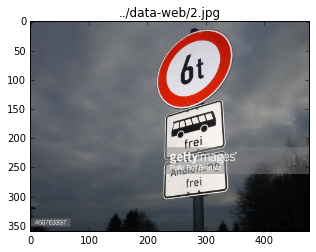

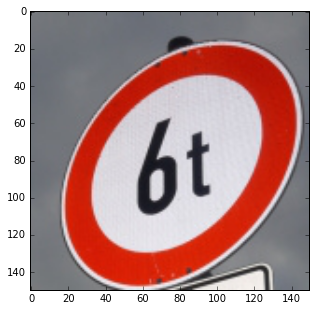

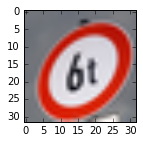

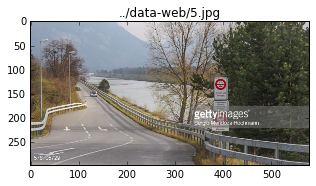

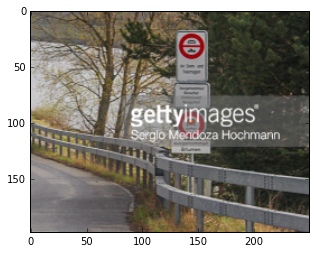

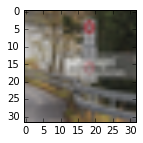

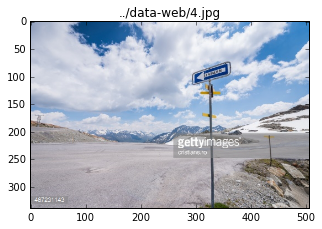

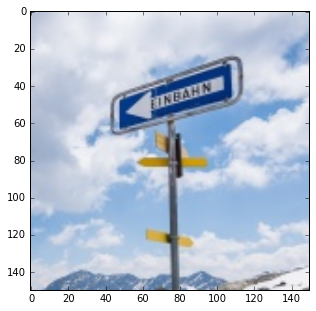

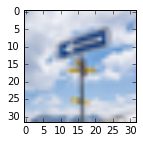

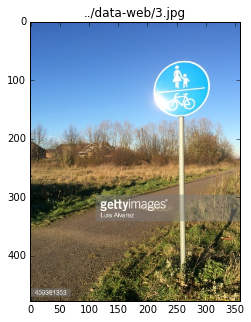

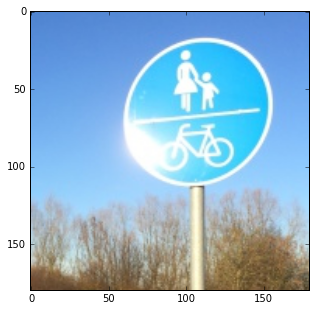

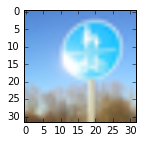

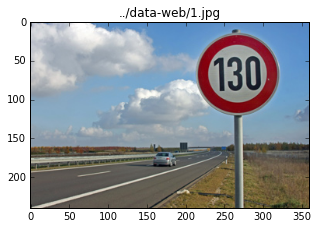

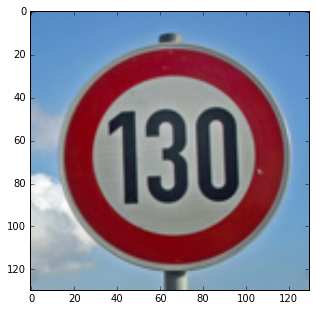

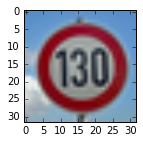

In [123]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

image_metas = {
    '../data-web/1.jpg': {
        'bbox': [(0, 200), (130,330)]
    }, 
    '../data-web/2.jpg': {
        'bbox': [(0,200), (150,350)]
    }, 
    '../data-web/3.jpg': {
        'bbox': [(50,150), (230,330)]
    }, 
    '../data-web/4.jpg': {
        'bbox': [(50,250), (200,400)]
    }, 
    '../data-web/5.jpg': {
        
        'bbox': [(100,250), (350,500)]
    }
}
new_images_data = np.zeros((5,32,32,3))
import numpy as np
for i, image_file in enumerate(image_metas.keys()):
    #image_data = cv2.imread(image_file,3)
    image_data = plt.imread(image_file)

    print (image_file)
    plt.figure(figsize=(5,5))
    plt.title(image_file)
    plt.imshow(image_data)
    
    if 'bbox' in image_metas[image_file]:
        bbox = image_metas[image_file]['bbox']
        image_sign = image_data[bbox[0][0]:bbox[1][0],bbox[0][1]:bbox[1][1],:]
        plt.figure(figsize=(5,5))
        plt.imshow(image_sign)    
        
        import PIL
        from PIL import Image
        image_sign_resize = Image.fromarray(image_sign).resize((32,32), Image.ANTIALIAS)
        image_sign_resize_array = np.array(image_sign_resize.convert("RGB") )
        plt.figure(figsize=(2,2))
        plt.imshow(image_sign_resize_array)    
        print (image_sign_resize_array.shape)
        new_images_data[i] = image_sign_resize_array
        
print (new_images_data.shape)


### Predict the Sign Type for Each Image

In [124]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

# Preprocess
new_images_data = mean_substraction(new_images_data)
new_images_data = normalize_images(new_images_data)
new_images_label = np.array([16, 41, 35, 27, 8])


### Analyze Performance

In [125]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    logit, loss, accuracy = sess.run([logits, loss_operation, accuracy_operation], feed_dict={x: new_images_data, y: new_images_label, keep_prob:1})

    #test_loss, test_accuracy = evaluate(new_images_data, new_images_label)
    print("Test Accuracy = {:.3f}".format(accuracy))
    


Test Accuracy = 0.200


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [126]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

print ('Pringing out the top five softmax probabilities and their corresponding predictions')

with tf.Session() as sess:
    print ( sess.run(tf.nn.top_k(tf.constant(logit), k=5)) )

Pringing out the top five softmax probabilities and their corresponding predictions
TopKV2(values=array([[ 23.66493607,  13.95875931,  12.47600842,   8.1551733 ,
          0.06454456],
       [ 12.88673496,   9.78807449,   8.63852978,   7.16585922,   5.4262681 ],
       [ 26.37099648,  16.31667328,  10.67291737,   6.12184334,
          6.01733255],
       [ 14.0453186 ,   9.54929924,   5.43571901,   4.39903879,
          4.26803017],
       [ 34.20708466,  22.33093834,   9.61820126,   8.33397102,   7.4609561 ]], dtype=float32), indices=array([[ 2,  3,  5,  1,  7],
       [22, 13, 26,  0,  1],
       [37, 26, 20, 17, 14],
       [38, 13, 36, 22,  1],
       [ 8,  1,  7,  2,  0]], dtype=int32))


---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 